In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker

In [8]:
# Read in data and assign X and y
data = pd.read_csv('/content/drive/MyDrive/IFT6758B/IFT6758B-Project-B10/Milestone2/features/train_data.csv', index_col=0)
data
X = data[['shot_distance', 'shot_angle' ]]
X = X.rename({'shot_distance': 'distanceFromNet', 'shot_angle': 'angleFromNet'}, axis=1)
X.interpolate(method='linear', inplace=True)
X

,distanceFromNet,angleFromNet
0,57.775427,23.459024
1,26.000000,0.000000
2,10.000000,0.000000
3,25.612497,38.659808
4,28.635642,24.775141
...,...,...
253470,12.529964,61.389540
253471,18.867962,32.005383
253472,18.027756,33.690068
253473,104.120123,16.172159


In [9]:
# Check for NaN values in the entire DataFrame 'X'
has_nan = X.isna().any().any()

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    X.interpolate(method='linear', inplace=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")

There are no NaN values in the DataFrame 'X'.


In [10]:
y = data[['is_goal']]
y

,is_goal
0,0
1,1
2,0
3,0
4,0
...,...
253470,1
253471,0
253472,0
253473,1


In [11]:
def Log_reg(X, y, feature_list):
    '''
    Arguments:
    X = pd.dataframe X
    y = target labels
    feature_list = list of features
    '''
    #print(X[feature_list])
    X_train,X_val,y_train,y_val = train_test_split(X[feature_list], y, test_size=0.2, random_state=42)

    # Logistic regression model fitting
    clf = LogisticRegression()
    y_train = y_train.values.ravel()
    clf.fit(X_train, y_train)

    # Predict on validation set
    y_pred = clf.predict(X_val)
    accuracy = metrics.accuracy_score(y_val, y_pred)

    #X_test_pred_proba = clf.predict_proba(X_test)
    pred_probs = clf.predict_proba(X_val)

    return X_val, y_val, y_pred, accuracy,  pred_probs

In [20]:
def plot_roc_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))

    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']

    for i, feature in enumerate(feature_list):
        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)
        print(f'Accuracy score is {accuracy}')

        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]

        probs_isgoal = pred_probs[:,1]
        fpr, tpr, _ = roc_curve(y_val,probs_isgoal)
        roc_auc = auc(fpr,tpr)

        plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2)

    #Random Baseline
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    fpr, tpr, _ = roc_curve(y_val,baseline_is_goal)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, color = plot_color, label = f'{plot_label} '+'AUC = %0.2f' % roc_auc, lw=2)


    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')

    plt.title('ROC Curves', fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'3a_ROC_curves.png')
    plt.show()

Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566


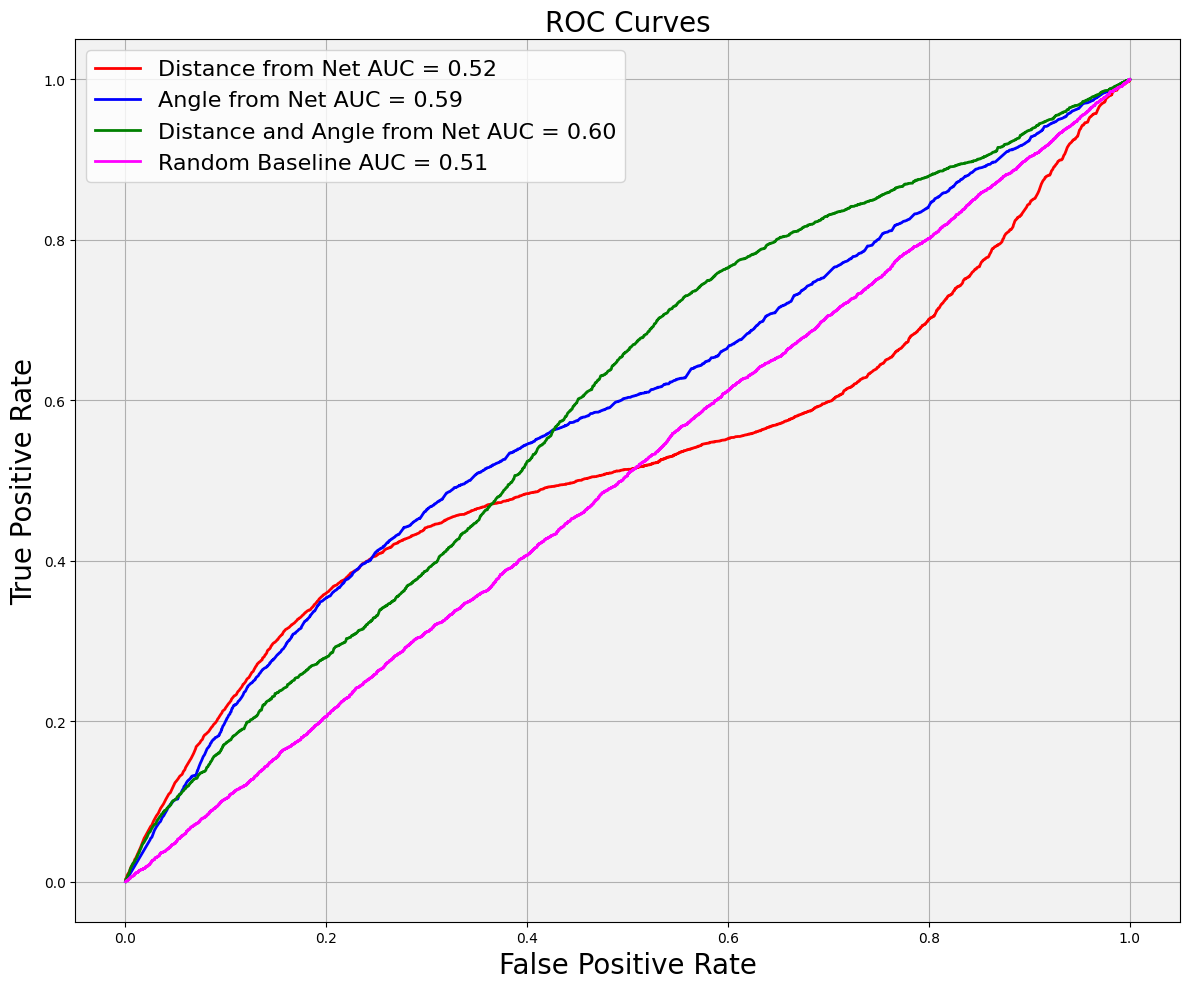

In [13]:
plot_roc_all_feat(X,y)

In [15]:
def calc_percentile(pred_probs, y_val):

    #Create a df for shot probabilities
    df_probs = pd.DataFrame(pred_probs)
    df_probs = df_probs.rename(columns={0: "Not_Goal_prob", 1: "Goal_prob"})

    # Combining 'Goal Probability' and 'is-goal' into one df.
    df_probs = pd.concat([df_probs["Goal_prob"].reset_index(drop=True), y_val["is_goal"].reset_index(drop=True)],axis=1)

    # Computing and adding Percentile Column
    percentile_values=df_probs['Goal_prob'].rank(pct=True)
    df_probs['Percentile'] = percentile_values*100
    df_percentile = df_probs.copy()

    return df_percentile

In [16]:
def goal_rate(df_percentile):

    rate_list = []

    # Find total number of goals
    total_goals = df_percentile['is_goal'].value_counts()[1]


    bin_width = 5

    i = 0
    i_list = []


    while i< (100-bin_width+1):  # 95 is the lower bound of last bin
        i_list.append(i)

        # i-th bin size
        bin_lower_bound = i
        bin_upper_bound = i + bin_width

        # finding rows have percentiles fall in this range
        bin_rows = df_percentile[(df_percentile['Percentile']>=bin_lower_bound) & (df_percentile['Percentile']<bin_upper_bound)]

        # Calculating the goal rate from total number of goals and shots in each bin_rows
        goals = bin_rows['is_goal'].value_counts()[1]
        shots = len(bin_rows) #total shots in bin_rows
        rate = (goals/shots)*100 # goal rate in pecerntage

        rate_list.append(rate)

        i+=bin_width

    # Creating a new dataframe Combining goal rate list and percentile list
    goal_rate_df = pd.DataFrame(list(zip(rate_list, i_list)),columns=['Rate', 'Percentile'])

    return goal_rate_df

In [21]:
def plot_goal_rate_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))

    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']

    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):

        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)
        print(f'Accuracy score is {accuracy}')

        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]

        df_percentile =  calc_percentile(pred_probs, y_val)
        goal_rate_df = goal_rate(df_percentile)
        goal_rate_x = goal_rate_df['Percentile']
        goal_rate_y = goal_rate_df['Rate']
        plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )


    #Random Baseline
    probs_isgoal = pred_probs[:,1]
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    no_baseline_goal = np.array([(1-i) for i in baseline_is_goal])
    random_probs = np.column_stack((baseline_is_goal, no_baseline_goal))
    df_percentile =  calc_percentile(random_probs, y_val)
    goal_rate_df = goal_rate(df_percentile)
    goal_rate_x = goal_rate_df['Percentile']
    goal_rate_y = goal_rate_df['Rate']

    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    plt.plot(goal_rate_x,goal_rate_y, color = plot_color, label = f'{plot_label}' )



    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')

    ax.set_ylim([0,100])
    ax.set_xlim([0,100])
    ax.invert_xaxis()
    major_ticks = np.arange(0, 110, 10)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)

    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)

    plt.grid(True)
    plt.title('Goal Rate', fontsize=20)
    plt.xlabel('Shot probability model percentile', fontsize=16)
    plt.ylabel('Goals / (Shots+Goals)%', fontsize=16)
    plt.legend(loc=2,prop={'size': 16})
    plt.tight_layout()
    plt.savefig(f'3b_goal_rates.png')
    plt.show()

Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566


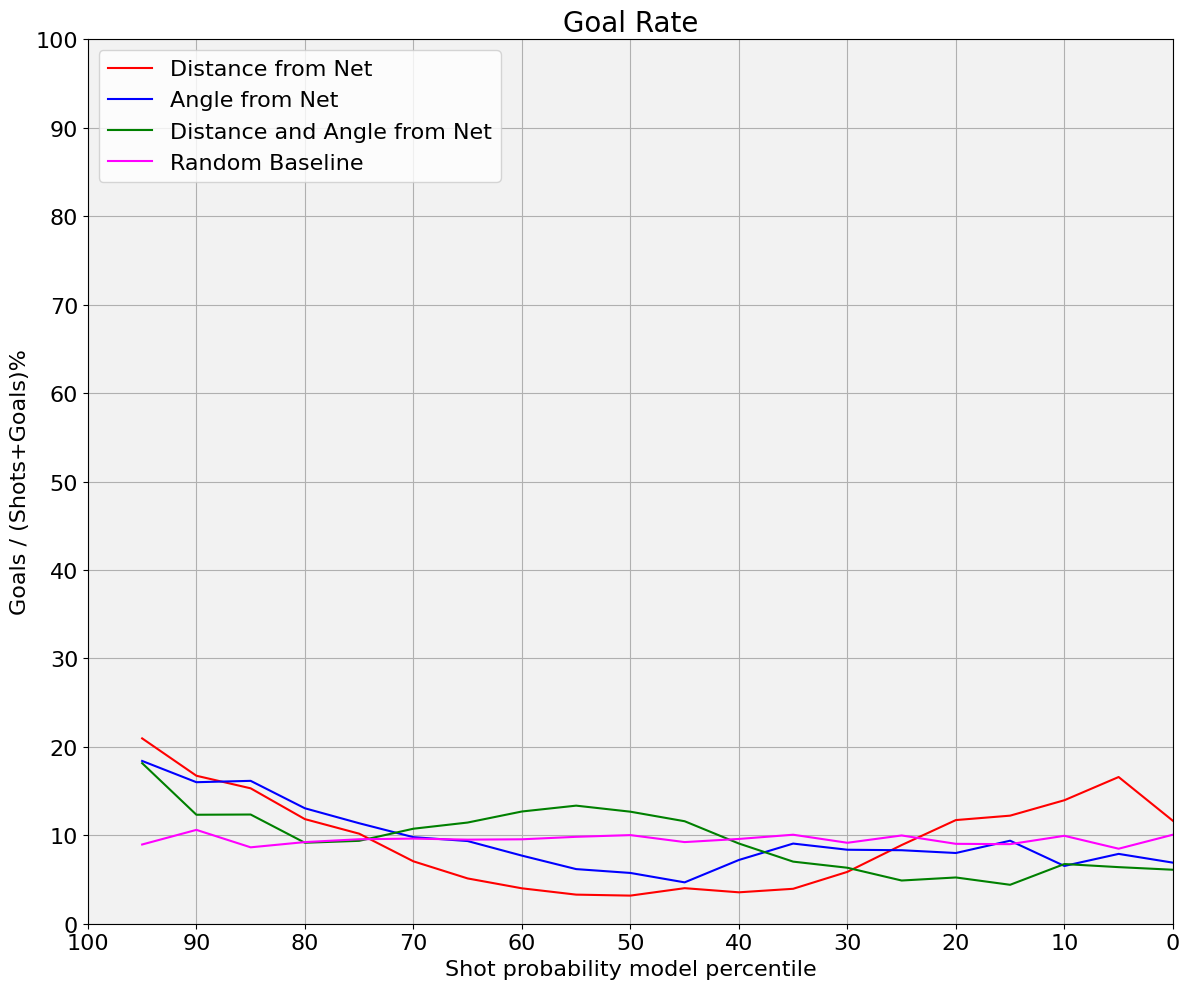

In [18]:
plot_goal_rate_all_feat(X,y)

In [24]:
def plot_cumulative_rate_all_feat(X, y):

    fig = plt.figure(figsize=(12,10))

    feature_list = (['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  )
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']

    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):

        X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)
        print(f'Accuracy score is {accuracy}')

        plot_color = feature_color_list[i]
        plot_label = plot_label_list[i]

        df_percentile =  calc_percentile(pred_probs, y_val)
        df_precentile_only_goal = df_percentile[df_percentile['is_goal'] == 1]
        ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile,
                              color=plot_color)



    #Random Baseline
    probs_isgoal = pred_probs[:,1]
    baseline_is_goal = np.random.uniform(0,1,probs_isgoal.shape[0])
    no_baseline_goal = np.array([(1-i) for i in baseline_is_goal])
    random_probs = np.column_stack((baseline_is_goal, no_baseline_goal))
    df_percentile =  calc_percentile(random_probs, y_val)
    df_precentile_only_goal = df_percentile[df_percentile['is_goal'] == 1]

    plot_color = 'Magenta'
    plot_label = 'Random Baseline'
    ax = sns.ecdfplot(data=df_precentile_only_goal, x=100 - df_precentile_only_goal.Percentile,
                              color=plot_color)


    ax = plt.gca()
    ax.grid()
    ax.set_facecolor('0.95')
    plt.yticks(np.arange(0, 1.05, 0.1))
    plt.xticks(np.arange(0, 100 * 1.01, 10))
    xvals = ax.get_xticks()
    ax.set_xticklabels(100 - xvals.astype(np.int32), fontsize=16)
    yvals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(y) for y in yvals], fontsize=16)
    ax.set_xlabel('Shot probability model percentile', fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_title(f"Cumulative % of Goals", fontsize=20)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    plot_label_list.append('Random Baseline')
    plt.legend(labels=plot_label_list, fontsize=16)
    plt.tight_layout()
    plt.savefig(f'3c_goal_proportions.png')
    plt.show()

Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566


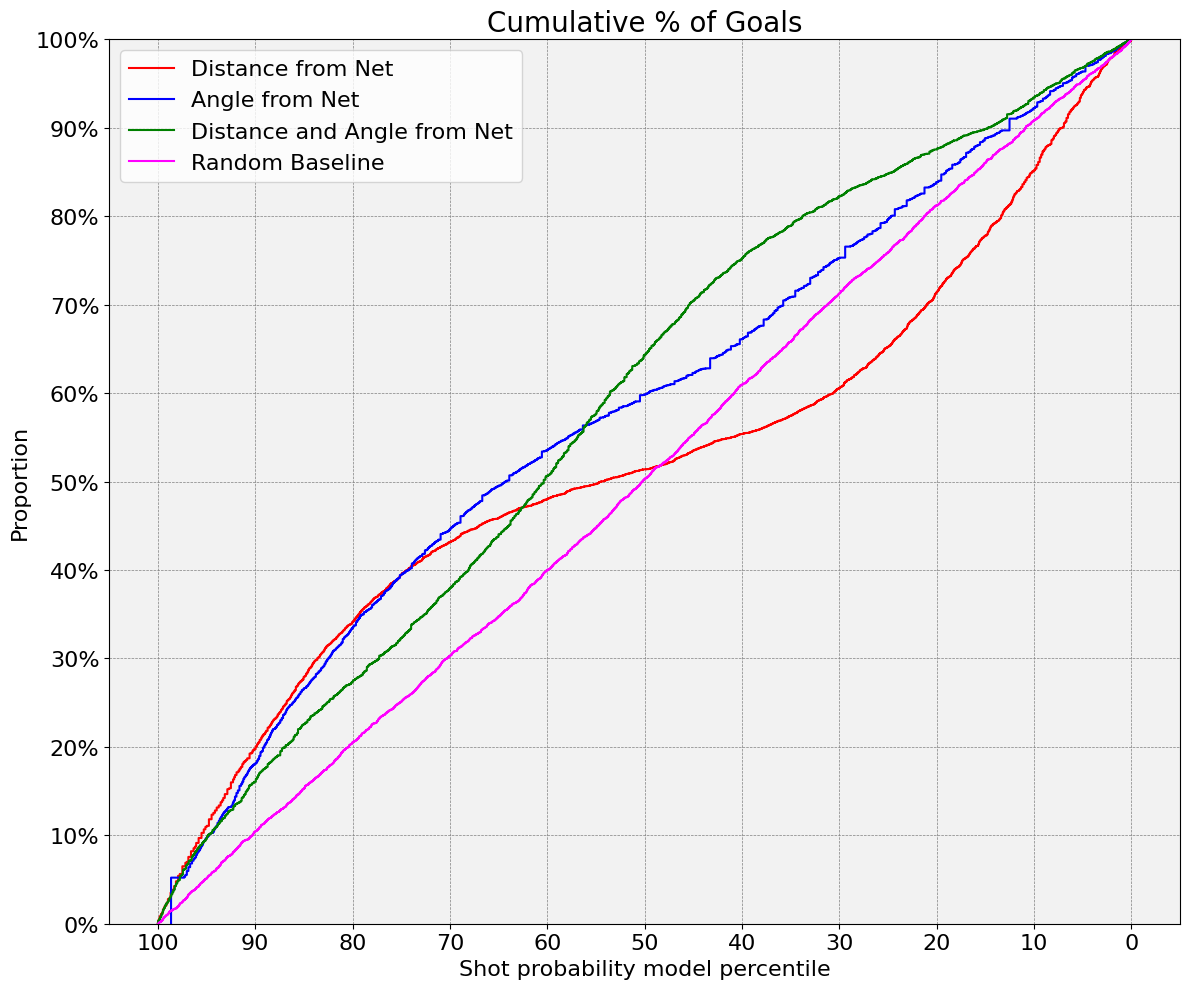

In [25]:
plot_cumulative_rate_all_feat(X, y)

In [26]:
def plot_calibration_all_feat(X, y):

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])

    feature_list = [['distanceFromNet'], ['angleFromNet'], ['distanceFromNet', 'angleFromNet']  ]
    feature_color_list = ['red', 'blue', 'green']
    plot_label_list = ['Distance from Net', 'Angle from Net', 'Distance and Angle from Net']

    feature_list.append('RandomBaseline')

    #if model_name == 'LR':
    for i, feature in enumerate(feature_list):

        if feature != 'RandomBaseline':

            X_val, y_val, y_pred, accuracy,  pred_probs = Log_reg(X, y, feature)
            print(f'Accuracy score is {accuracy}')

            y_val_is_goal = y_val['is_goal']
            pred_probs_is_goal = pred_probs[:,1]

            plot_color = feature_color_list[i]
            plot_label = plot_label_list[i]

        else:
            random_goal_prob = np.random.uniform(0, 1, len(y_val))

            y_val_is_goal = y_val['is_goal']
            pred_probs_is_goal = random_goal_prob.copy()

            plot_color = 'magenta'
            plot_label = 'Random Baseline'


        ax_display = CalibrationDisplay.from_predictions(y_val_is_goal,pred_probs_is_goal, n_bins=50,
                                                             ax=ax_calibration_curve, color=plot_color, label=plot_label)


    ax = plt.gca()
    ax.set_facecolor('0.95')
    ax_calibration_curve.grid()

    plt.title("Calibration plots", fontsize=20)
    plt.legend(loc=2,prop={'size': 16})
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.ylabel('Fraction of positives', fontsize=20)
    plt.xlabel('Mean predicted probability', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'3d_calibration_plots.png')
    plt.show()

Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566
Accuracy score is 0.9049807673340566


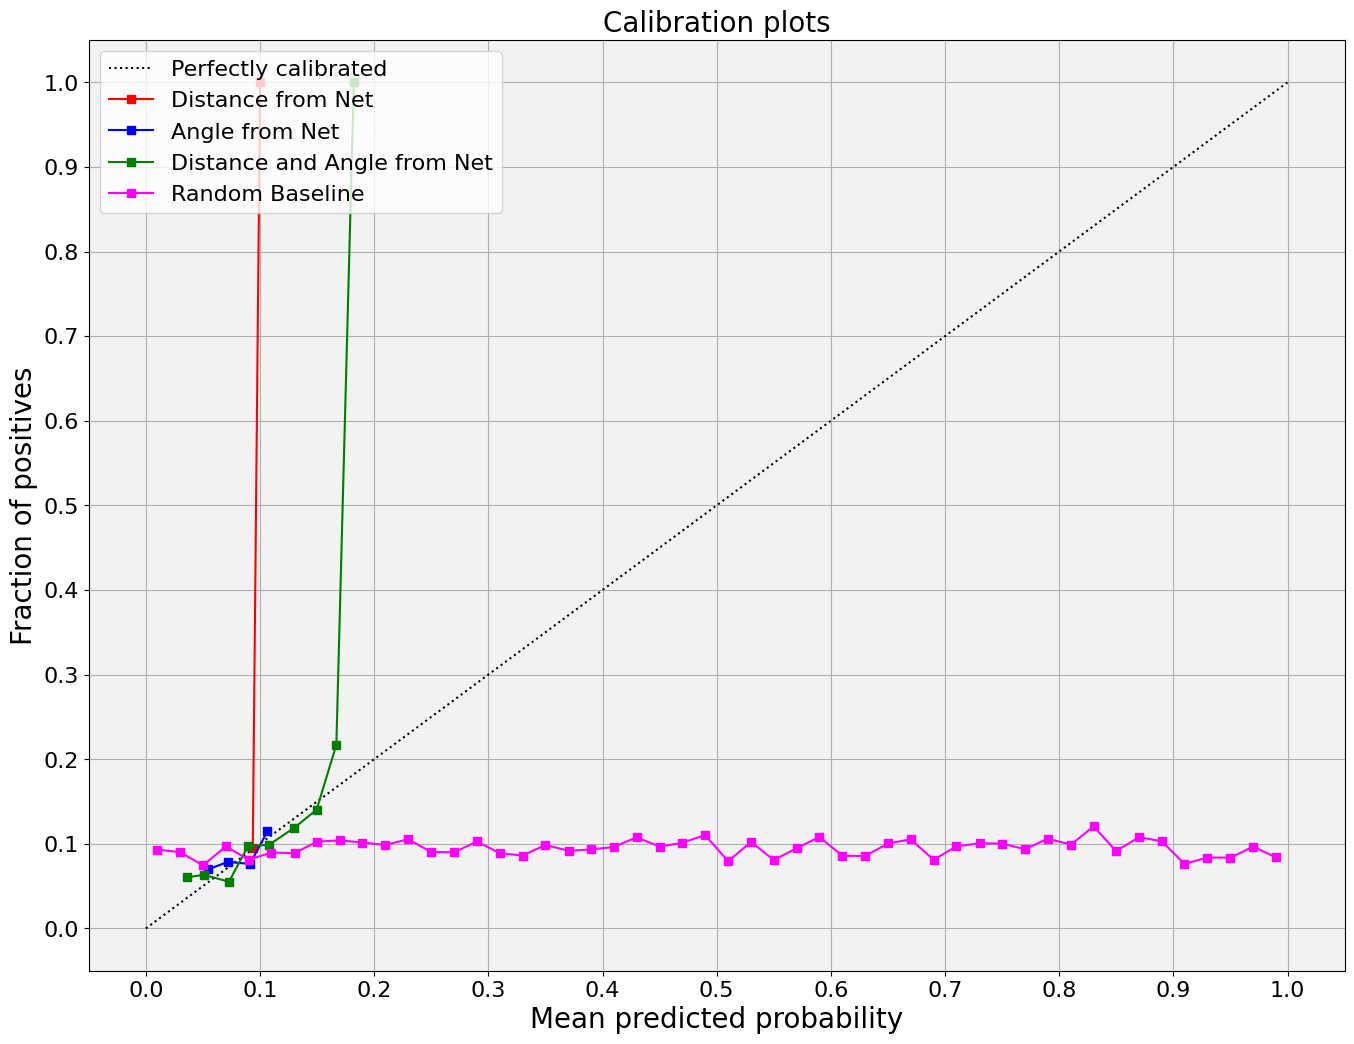

In [27]:
plot_calibration_all_feat(X, y)